# Project Summary

- Used a webscraper to find all the SonarSource rules (https://rules.sonarsource.com/).
- Used a webscraper to find all* SonarCommunity forum posts (https://community.sonarsource.com/) discussing those rules.
- Pre-processed and cleaned the data to calculate a 'Controversy Score' per each blog post.
- Created a neural network model to find a correlation between how (the description) a rule is written + it's attributes to see if it can reliability predict the controversy of a never-before-seen rule.

All code at https://github.com/jkerndev/SonarQube-Controversy

* "all" meaning using a robust regex scanning function to search the mainpost for rule references; a small margin of posts discussing rules may have been unpreventably missed.

# Packages

In [67]:
!pip install torch torchvision 
!pip install xgboost
!pip install transformers
!pip install Unidecode
!pip install nltk
!pip install seaborn

# Imports

In [68]:
import json
import re
import unidecode
import nltk
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from datetime import datetime
from torch.utils.data import DataLoader, TensorDataset, random_split
from transformers import AutoTokenizer, AutoModel
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, classification_report
from warnings import simplefilter

# Globals

In [69]:
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)  # Filter out Pandas performance warnings
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")
bert_model = AutoModel.from_pretrained("google-bert/bert-base-uncased")

# Pre-Processing Functions

In [70]:
def get_posts():
    with open('posts.json', "r") as f:
        posts = json.load(f)
    return posts

def get_rules():
    with open('rules.json', "r") as f:
        rules = json.load(f)
    return rules

def target_information(series):
    print("INFO: Distribution of target...")
    mean = np.mean(series)
    median = np.median(series)
    stddev = np.std(series)
    max = series.max()
    print(f"INFO: Mean of target: {mean}")
    print(f"INFO: Median of target: {median}")
    print(f"INFO: Std. Dev. of target: {stddev}")
    print(f"INFO: Max Value of target: {max}")

    counts, bins = np.histogram(series)
    plt.stairs(counts, bins)
    plt.title('Controversy Score Distribution')
    plt.xlabel('Controversy Score')
    plt.ylabel('Frequency')
    plt.show()
    return mean, median, stddev, max

def count_and_remove_codeblocks(text):
    # Remove codeblock indicators and the code between
    code_start_indices = list(re.finditer(r'CODEBLOCK_START', text))
    code_end_indices = list(re.finditer(r'CODEBLOCK_END', text))

    # Number of code references
    code_ref_count = len(code_start_indices)

    # Delete code from descriptions
    for start, end in zip(reversed(code_start_indices), reversed(code_end_indices)):
        text = text[:start.start()] + text[end.end():]

    # Delete other well-defined code-related headers
    code_tells = [r"(\s)Noncompliant code example(\s)", r"(\s)Compliant solution(\s)", r"(\s)Exceptions(\s)"]
    for tell in code_tells:
        text = re.sub(tell, ' ', text)

    return text, code_ref_count

def clean_description(text):
    # Remove newline characters
    text = re.sub(r'\\n', ' ', text)
    # Decode unicode
    text = unidecode.unidecode(text)
    # Reduce multiple spaces to single spaces
    text = re.sub(r'\s+', ' ', text).strip()
    # Remove non-text
    text = re.sub(r'[^\w\s]', ' ', text) 
    # Remove stop words
    stops = set(stopwords.words("english")) 
    words = word_tokenize(text.lower())
    meaningful_words = [w for w in words if not w in stops]   
    # Stem words
    snow_stemmer = SnowballStemmer(language='english')
    words = ([snow_stemmer.stem(w) for w in meaningful_words])
    text = " ".join(words)

    return text

# Data Pre-processing:

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jason\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Jason\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


INFO: 4933 Sonar rules did not have any controversy scores associated with them out of 5892.
INFO: Learning will utilize 959 rules with a corresponding controversy score out of 5892 total rules.
INFO: Distribution of target...
INFO: Mean of target: 0.21928056702909537
INFO: Median of target: 0.21001241383557326
INFO: Std. Dev. of target: 0.0761906853761417
INFO: Max Value of target: 0.5327472838777081


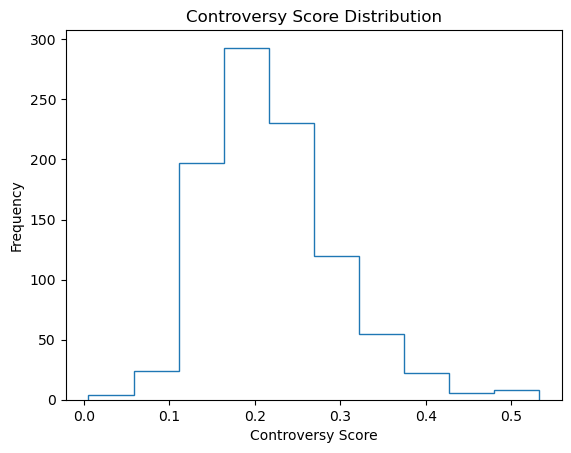

In [71]:
    weights = {
        "user_count": 0.10, 
        "main_post_likes": 0.2, 
        "mean_comment_likes": 0.15,
        "stddev_comment_likes": 0.05, 
        "code_references": 0.2, 
        "replies": 0.1, 
        "views": 0.15, 
        'adjusted_time_gap': 0.3  
    }

    posts = get_posts()
    rules = get_rules()

    rules_df = pd.DataFrame.from_dict(rules)

    # Map combined rule codes to corresponding rule entries
    rules_df['rule'] = rules_df.apply(lambda row: f"{row['language']}:{row['code']}", axis=1)

    # Clean rule descriptions
    rules_df[['description', 'codeblock_count']] = rules_df['description'].apply(
        lambda desc: pd.Series(count_and_remove_codeblocks(desc))
    )
    nltk.download('stopwords')
    nltk.download('punkt_tab')
    rules_df['description'] = rules_df['description'].apply(clean_description)

    posts_df = pd.DataFrame.from_dict(posts)
    # Remove duplicates (occurs when scraper had to be re-run from a checkpoint due to a network error)
    posts_df.drop_duplicates('id')

    numeric_cols = ["link_count", "user_count", "main_post_likes", "code_references", "mean_comment_likes", "stddev_comment_likes", "comment_likes", "replies", "views"]
    for col in numeric_cols: 
        posts_df[col] = pd.to_numeric(posts_df[col])

    # Calculate the time gap in days
    posts_df['created'] = pd.to_datetime(posts_df['datetimes'].apply(lambda x: x['created']))
    posts_df['latest'] = pd.to_datetime(posts_df['datetimes'].apply(lambda x: x['latest']))
    posts_df['time_gap_days'] = (posts_df['latest'] - posts_df['created']).dt.days
    posts_df['age_days'] = (datetime.now() - posts_df['created']).dt.days

    # Decay constant
    decay_constant = 365 * 2  # Decay over about 2 years

    # Calculate the decay factor based on age
    posts_df['decay_factor'] = np.exp(-posts_df['age_days'] / decay_constant)

    # Apply decay to the time gap (so that older posts, with more time to seed themselves in SEO, don't skew the complexity score)
    # posts_df['adjusted_time_gap'] = posts_df['time_gap_days'] * posts_df['decay_factor']
    posts_df['adjusted_time_gap'] = posts_df['time_gap_days'] * posts_df['decay_factor']

    # Calculate and normalize complexity scores
    scaler = MinMaxScaler()
    numeric_cols.append('adjusted_time_gap')
    posts_df[numeric_cols] = scaler.fit_transform(posts_df[numeric_cols])

    total_weight = sum(weights.values())
    normalized_weights = {k: v / total_weight for k, v in weights.items()}

    posts_df['controversy_score'] = (
        posts_df['user_count'] * normalized_weights['user_count'] +
        posts_df['main_post_likes'] * normalized_weights['main_post_likes'] +
        posts_df['mean_comment_likes'] * normalized_weights['mean_comment_likes'] +
        posts_df['stddev_comment_likes'] * normalized_weights['stddev_comment_likes'] +
        posts_df['code_references'] * normalized_weights['code_references'] +
        posts_df['replies'] * normalized_weights['replies'] +
        posts_df['views'] * normalized_weights['views'] + 
        posts_df['adjusted_time_gap'] * normalized_weights['adjusted_time_gap']
    )

    # Match post controversy scores to their referenced rules
    posts_df['rule'] = posts_df['rule']
    controversy_per_rule = posts_df.groupby('rule')['controversy_score'].apply(list).reset_index()
    
    # Merge the aggregated scores back into rules_df
    rules_df = rules_df.merge(controversy_per_rule, on='rule', how='left')
    rules_df['controversy_score'] = rules_df['controversy_score'].apply(lambda d: d if isinstance(d, list) else [0]) # Missing scores (no controversy found)
    missing_count = rules_df['controversy_score'].apply(lambda x: x == [0]).sum()
    print(f"INFO: {missing_count} Sonar rules did not have any controversy scores associated with them out of {len(rules_df)}.")

    # Controversy score (averaged) distributions of those not equal to 0
    # Keep rows where controversy_score != [0]
    non_zero_controversy = rules_df.loc[rules_df['controversy_score'].apply(lambda x: x != [0])]
    print(f"INFO: Learning will utilize {len(non_zero_controversy.index)} rules with a corresponding controversy score out of {len(rules_df)} total rules.")
    controversy_scores_means = non_zero_controversy['controversy_score'].apply(np.mean).apply(np.sqrt).values
    data_mean, data_median, data_stddev, data_max = target_information(controversy_scores_means)

    # Save combined data
    cleanData = 'posts-cleaned.json'

    with open(cleanData, 'w') as file:
        file.write(rules_df.to_json(orient = "records"))

# Modelling:

## Functions

In [72]:
# From running data-scraping and cleaning code
def get_data():
    with open('../Data/posts-cleaned.json', "r") as f:
        data = json.load(f)
    
    return data

def get_bert_embedding(sentence, tokenizer, model):
    inputs = tokenizer(sentence, return_tensors="pt", truncation=True, padding=True, max_length=256)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

# Define the neural network classifier model
class ControversyClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(ControversyClassifier, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)  # Output size = number of bins
        )
    
    def forward(self, x):
        return self.fc(x)

## Data Initialization

target_bin_label
low            963
low-medium     633
none           511
very low       467
medium         223
medium-high    177
high             6
Name: count, dtype: int64


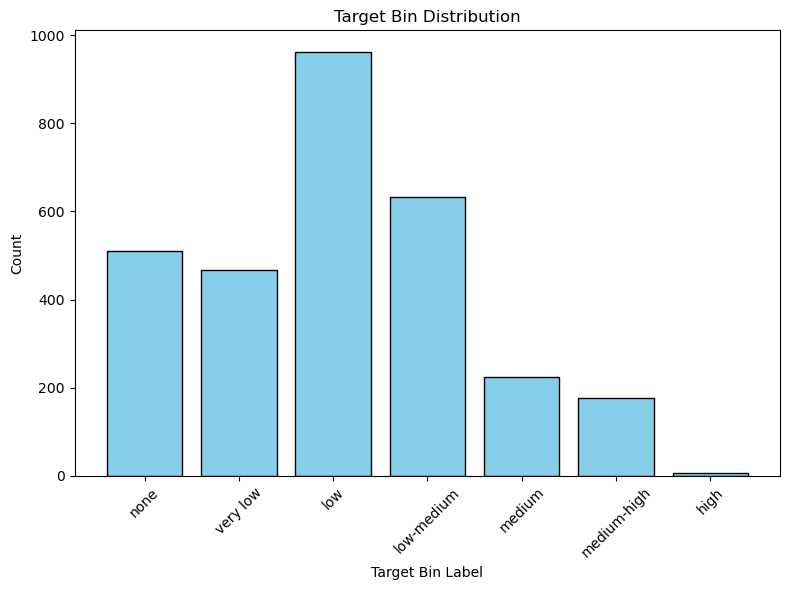

In [73]:
    # Bin Definitions (data from stretched averages during pre-processing above)
    bins = [
        0,                                           # None
        data_mean - 2*data_stddev,                   # Very Low
        data_mean - data_stddev,                     # Low
        data_mean,                                   # Low-Medium
        data_mean + data_stddev,                     # Medium
        data_mean + 2*data_stddev,                   # Medium-High
        data_max                                     # High and above
    ]

    # Label the bins
    bin_labels = ['none', 'very low', 'low', 'low-medium', 'medium', 'medium-high', 'high']

    simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
    tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")
    bert_model = AutoModel.from_pretrained("google-bert/bert-base-uncased")

    # Obtain posts
    data_init = get_data()
    df = pd.DataFrame.from_dict(data_init)

    # --------------
    # Assemble data for training
    # --------------

    # Filter rows with controversy_score == [0] and sample 10% of them
    zero_controversy_sample = df.loc[df['controversy_score'].apply(lambda x: x == [0])].sample(frac=0.10, random_state=42)

    # Keep rows where controversy_score != [0]
    non_zero_controversy = df.loc[df['controversy_score'].apply(lambda x: x != [0])]

    # Combine the sampled [0] rows with the non-zero controversy rows
    df = pd.concat([non_zero_controversy, zero_controversy_sample], ignore_index=True)

    # Expand rows based on the controversy_score list
    df = df.explode('controversy_score', ignore_index=True)

    # Ensure the controversy_score is now numeric
    df['controversy_score'] = df['controversy_score'].astype(float)

    # --------------
    # Feature initialization
    # --------------

    # BERT Description Transformer
    df['description'] = df['description'].apply(lambda x: get_bert_embedding(x, tokenizer, bert_model))

    # List of categories to process (categories containing a list of strings)
    multi_cats = ['attributes', 'impacts', 'tags']

    # Iterate through each category
    for cat in multi_cats:
        # Flatten the list of strings in the current column into unique values
        all_unique_values = set([item for sublist in df[cat] for item in sublist])
        temp_df = pd.DataFrame()
        # For each unique value, create a new boolean column
        for value in all_unique_values:
            # Mark the presence (True/False) of the value in each row for this column
            temp_df[f"{cat}_{value}"] = df[cat].apply(lambda x: value in x)
        
        df = pd.concat([df, temp_df], axis=1)

    # One-hot encoding for the categories
    ohe_cats = ["language", "type", "severity", "quick_fix"]
    df = pd.get_dummies(df, columns=ohe_cats, drop_first=True)

    # Combine features
    X = np.hstack([
        np.vstack(df['description'].to_list()),                                                                     # Semantic embeddings                                         
        df.drop(columns=['controversy_score']).select_dtypes(include=['uint8', 'int64', 'float64', 'bool']).values  # Encodings and numerics 
    ])

    df['split_controversy_score'] = np.sqrt(df['controversy_score']) # Stretch values
    
    # Assign each target value to a bin
    df['target_bin'] = np.digitize(df['split_controversy_score'], bins) - 1
    df['target_bin_label'] = [bin_labels[i] for i in df['target_bin']]

    # Verify bin counts
    print(df['target_bin_label'].value_counts())

    # Count the occurrences of each bin
    bin_counts = df['target_bin_label'].value_counts().reindex(bin_labels, fill_value=0)
    
    # Create a bar chart
    plt.figure(figsize=(8, 6))
    plt.bar(bin_counts.index, bin_counts.values, color='skyblue', edgecolor='black')
    plt.xlabel('Target Bin Label')
    plt.ylabel('Count')
    plt.title('Target Bin Distribution')
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.tight_layout()
    plt.show()

    # Target
    y = df['target_bin'].values

## Model Training

Epoch 1/50, Train Loss: 1.6853, Train Accuracy: 0.3100
Epoch 2/50, Train Loss: 1.6227, Train Accuracy: 0.3205
Epoch 3/50, Train Loss: 1.5841, Train Accuracy: 0.3586
Epoch 4/50, Train Loss: 1.5382, Train Accuracy: 0.3750
Epoch 5/50, Train Loss: 1.5088, Train Accuracy: 0.3939
Epoch 6/50, Train Loss: 1.4782, Train Accuracy: 0.4136
Epoch 7/50, Train Loss: 1.4537, Train Accuracy: 0.4258
Epoch 8/50, Train Loss: 1.4273, Train Accuracy: 0.4371
Epoch 9/50, Train Loss: 1.4032, Train Accuracy: 0.4379
Epoch 10/50, Train Loss: 1.3704, Train Accuracy: 0.4639
Epoch 11/50, Train Loss: 1.3607, Train Accuracy: 0.4585
Epoch 12/50, Train Loss: 1.3418, Train Accuracy: 0.4639
Epoch 13/50, Train Loss: 1.3293, Train Accuracy: 0.4715
Epoch 14/50, Train Loss: 1.3238, Train Accuracy: 0.4757
Epoch 15/50, Train Loss: 1.2948, Train Accuracy: 0.4924
Epoch 16/50, Train Loss: 1.2708, Train Accuracy: 0.5042
Epoch 17/50, Train Loss: 1.2672, Train Accuracy: 0.5021
Epoch 18/50, Train Loss: 1.2572, Train Accuracy: 0.4996
E

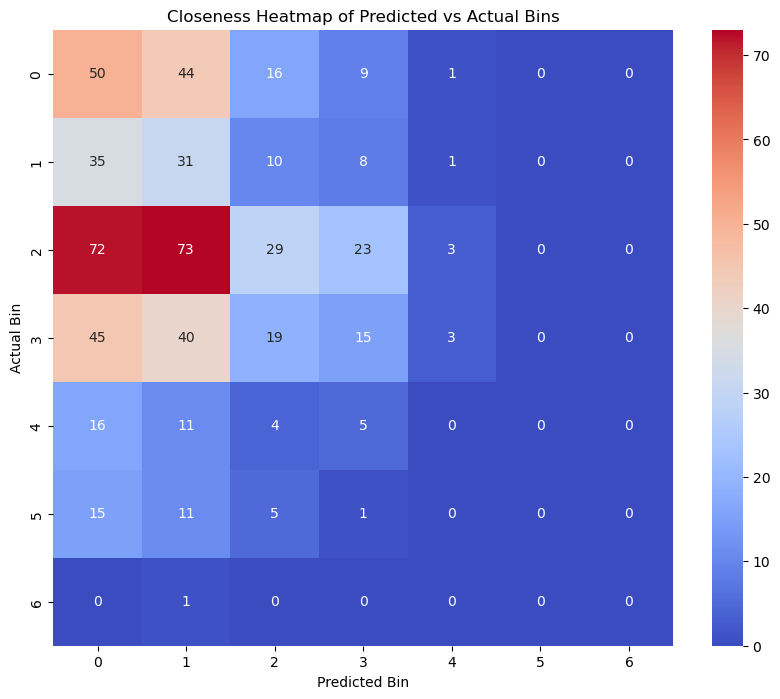

In [74]:
    # --------------
    # Model training
    # --------------
    torch.manual_seed(42)

    X = X.astype(np.float64)
    num_bins = len(bins)
    model = ControversyClassifier(input_size=X.shape[1], num_classes=num_bins)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Convert X and y to PyTorch tensors
    X_tensor = torch.from_numpy(X).float()  # Ensure float type for X
    y_tensor = torch.tensor(y, dtype=torch.long)  # Targets as long
    
    # Combine into a dataset
    dataset = TensorDataset(X_tensor, y_tensor)
    
    # Split dataset into training and testing sets
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
    
    # Define data loaders for batching
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)
    
    # Initialize model, loss function, and optimizer
    input_size = X.shape[1]
    model = ControversyClassifier(input_size, num_bins) 
    criterion = nn.CrossEntropyLoss()  # Use CrossEntropyLoss for classification
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Training loop
    epochs = 50
    for epoch in range(epochs):
        model.train()  # Set model to training mode
        train_loss = 0
        correct = 0
        total = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()                                   # Clear gradients
            predictions = model(X_batch)                            # Forward pass 
            
            # Compute loss
            loss = criterion(predictions, y_batch)
            loss.backward()                                         # Backpropagation
            optimizer.step()                                        # Update weights
    
            # Track loss
            train_loss += loss.item()
    
            # Compute accuracy
            _, predicted_classes = torch.max(predictions, 1)        # Get predicted class indices
            correct += (predicted_classes == y_batch).sum().item()  # Count correct predictions
            total += y_batch.size(0)                                # Total number of samples
    
        # Average loss and accuracy per epoch
        train_loss /= len(train_loader)
        accuracy = correct / total
        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {accuracy:.4f}")

    # Evaluate the model
    print("\n-----\n ACCURACY RESULTS \n-----\n")
    model.eval()  # Set model to evaluation mode
    correct = 0
    correct2 = 0  # Correct if bin is correct or within 1 bin off
    total = 0
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            predictions = model(X_batch.to(torch.float32))
            predicted_classes = predictions.argmax(dim=1)
            all_predictions.extend(predicted_classes.tolist())
            all_targets.extend(y_batch.tolist())
            
            correct += (predicted_classes == y_batch).sum().item()
            
            # Check for cases where bin is within 1 off
            bin_diff = torch.abs(predicted_classes - y_batch)
            correct2 += (bin_diff <= 1).sum().item()
            
            total += y_batch.size(0)
    
    accuracy = correct / total
    accuracy2 = correct2 / total  # New accuracy metric for +/- 1 bin match
    print(f"Plain 1-1 bin accuracy: {accuracy:.4f}")
    print(f"Correct within 1 bin accuracy: {accuracy2:.4f}")
    
    # Classification metrics
    print(classification_report(all_targets, all_predictions))
    
    # Initialize list to store differences
    bin_differences = []
    
    # Collect bin differences for the entire dataset
    with torch.no_grad():  # No gradients during evaluation
        for X_batch, y_batch in test_loader:
            predictions = model(X_batch)  
            _, predicted_classes = torch.max(predictions, 1)  
            bin_diff = (predicted_classes - y_batch).abs().cpu().numpy()
            bin_differences.extend(bin_diff)
    
    bin_differences = np.array(bin_differences)
    
    # Create a heatmap grid
    heatmap_data = np.zeros((num_bins, num_bins), dtype=int)  # num_bins x num_bins grid
    
    # Populate the heatmap data with the bin differences
    for actual, predicted in zip(all_targets, bin_differences):  
        heatmap_data[actual, predicted] += 1
    
    # Plot heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='coolwarm', cbar=True,
                xticklabels=np.arange(num_bins), yticklabels=np.arange(num_bins))
    plt.title('Closeness Heatmap of Predicted vs Actual Bins')
    plt.xlabel('Predicted Bin')
    plt.ylabel('Actual Bin')
    plt.show()

#### Results:

- The accuracy between the predicted bin and actual bin is 39.1%, which is not very accurate
- The accuracy between the predicted bin and actual bin (+/- 1 bin) is 74.5%, which is reasonably accurate

Given these results, I think there is some merit for this model to be valuable. The team running the SonarCommunity site could utilize internal APIs to gather more reliable data (code segments, updated data, text that doesn't require processing, additional metrics, etc.) to make the results more reliable and accurate. As the model is now, 75% accuracy for +/- 1 bin is good as an educated guess for how controversial a new rule would be and, with additional time and insights, could be utilized to make informed business decisions about how much time and effort should be dedicated to formulating a new rule to ensure it doesn't generate controversy.